## Importing libraries

In [46]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
!pip install tqdm
from tqdm.notebook import tqdm
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import torch
from google.colab import output
output.enable_custom_widget_manager()
import random
np.random.seed(42)
random.seed(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Train Validation Test Split

In [47]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
images = np.append(x_train,x_test,axis=0)
labels = np.append(y_train,y_test)
x, x_test, y, y_test = train_test_split(images,labels,test_size=0.2,train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.25,train_size =0.75)


## Nearest Neighbour Classification

In [48]:
def knn(inp,k):
  """
  kNN Classifier based on L2 Distance

  Inputs: 
    - inp: vector of input image
    - k: No.of neigbours to consider before assigning class label prediction
  """

  dist = []

  for i in x_train:
    dist.append((np.sum((inp-i)**2)))

  lst = [x for _, x in sorted(zip(dist, y_train))][:k]

  return max(set(lst), key=lst.count) # Return maximally occuring class amongst k nearest neighbours

In [49]:
def knn_predict(inp,k):
  '''
  Prediction function for kNN Classifier

  Inputs: 
    - inp: List of vectors of input images
    - k: No.of neigbours to consider before assigning class label prediction
  '''

  preds = []
  for i in tqdm(inp):
    preds.append(knn(i,k))
  return preds # List of Prediction labels

In [50]:
  for k in tqdm(range(1,10)):
    print("For k = {}, accuracy is {} %".format(k,accuracy_score(y_val.flatten()[:10],knn_predict(x_val[:10],k))*100))

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

For k = 1, accuracy is 30.0 %


  0%|          | 0/10 [00:00<?, ?it/s]

For k = 2, accuracy is 30.0 %


  0%|          | 0/10 [00:00<?, ?it/s]

For k = 3, accuracy is 30.0 %


  0%|          | 0/10 [00:00<?, ?it/s]

For k = 4, accuracy is 40.0 %


  0%|          | 0/10 [00:00<?, ?it/s]

For k = 5, accuracy is 20.0 %


  0%|          | 0/10 [00:00<?, ?it/s]

For k = 6, accuracy is 30.0 %


  0%|          | 0/10 [00:00<?, ?it/s]

For k = 7, accuracy is 20.0 %


  0%|          | 0/10 [00:00<?, ?it/s]

For k = 8, accuracy is 20.0 %


  0%|          | 0/10 [00:00<?, ?it/s]

For k = 9, accuracy is 20.0 %


In [60]:
print("For k = {}, test accuracy is {} %".format(4,accuracy_score(y_test.flatten()[:10],knn_predict(x_test[:10],4))*100))

  0%|          | 0/10 [00:00<?, ?it/s]

For k = 4, test accuracy is 20.0 %


**Results:** k = 4 results in maximum validation accuracy of 40% and testing accuracy of 20%

**NOTE**: Only 10 images were selected during testing to minimize time taken to run. 

------------------------------------------------------------------------
## Hinge loss

In [79]:
def hinge_loss(score,labels,idx,i,dW,loss):
  '''
  Implementation of Hinge Loss or SVM Loss

  Inputs:
    - score: Scoring function output
    - labels: List of training image labels
    - idx: Index of curre/nt image in input batch
    - i: 3D Image numpy array
    - dW: Empty gradient array 
    - loss: Value of Loss
  '''

  for j in range(10): # 10 = No.of classes in Cifar-10

      if j != labels[idx]-1:
        hinge = score[j] - score[labels[idx]-1] + 1

        if hinge > 0:
          loss += hinge 
          dW[:, labels[idx]] -= i.flatten()
          dW[:,j] += i.flatten()

  return dW,loss # Updated gradient and loss value

## Softmax Loss

In [80]:
def softmax_loss(score,labels,idx,i,dW,loss):
  '''
  Implementation of Softmax Loss
  
  Inputs:
    - score: Scoring function output
    - labels: List of training image labels
    - idx: Index of current image in input batch
    - i: 3D Image numpy array
    - dW: Empty gradient array 
    - loss: Value of Loss
  '''

  softmax = np.exp(score)/np.sum(np.exp(score))
  loss += -np.log(softmax[labels[idx]])

  for j in range(10): # 10 = No.of classes in Cifar-10
    dW[:,j] += i.flatten() * softmax[j]
  
  dW[:,labels[idx]] -= i.flatten()
  
  return dW,loss # Updated gradient and loss value


## Model Training

In [81]:
def train(W,images,labels,reg,loss_function='softmax'):

  '''
  Training function

  Inputs:
    - W: Weight matrix
    - images: Batch of training images
    - labels: Class labels for training images
    - reg = Regularization
    - loss_function: Type of loss function to use.
          2 options - 'softmax' or 'hinge'
  '''
  
  loss = 0
  dW = np.zeros((3072,10))

  for idx, i in enumerate(images):

    score = (np.dot(i.flatten().reshape(1,-1),W)).ravel()

    if loss_function == 'softmax':
      dW,loss = softmax_loss(score,labels,idx,i,dW,loss)

    else:
      dW,loss = hinge_loss(score,labels,idx,i,dW,loss)

    
  loss /= images.shape[0]
  dW = dW / images.shape[0]

  loss += reg * np.sum(W * W)
  dW = dW + reg * 2 * W 
      
  return loss, dW # Updated loss value and gradient


## Model Functions

In [82]:
def SVM(X,y,learning_rate,reg,epochs,X_val,y_val):
  '''
  Inputs:
    - X: Training images
    - y: Training labels
    - learning_rate: Learning rate (alpha) value
    - reg: Regularization value
    - epochs: No.of epochs to be trained for
    - X_val: Validation images
    - y_val: Validation labels
  '''

  W = 0.001 * np.random.rand(3072,10)
  loss_history = []
  loss_function = 'hinge'
  print('Loss function used:',loss_function)
  print("----------------------------------")
  train_acc = 0
  val_acc = []

  for i in tqdm(range(epochs)):
    loss, grad = train(W,X,y,reg,loss_function)
    loss_history.append(loss)

    # learning_rate = lr_scheduler(learning_rate,i)
    W = W - learning_rate * grad

    train_preds = predict(W,X)
    val_preds = predict(W,X_val)

    train_acc = accuracy_score(y,train_preds)
    val_acc.append(accuracy_score(y_val,val_preds))
    
    print("EPOCH {}/{} | Training loss: {:.2f} | Training accuracy: {:.2f} | Validation accuracy: {:.2f}".format(i,epochs,loss,train_acc,val_acc[-1]))

  print()
  plt.plot(loss_history)
  plt.xlabel('Epochs')
  plt.ylabel('Loss value')
  plt.show()

  return W, loss_history, val_acc # Model weights, list of loss value history and list of validation accuracies


In [83]:
def Softmax(X,y,learning_rate,reg,epochs,X_val,y_val):
  '''
  Inputs:
    - X: Training images
    - y: Training labels
    - learning_rate: Learning rate (alpha) value
    - reg: Regularization value
    - epochs: No.of epochs to be trained for
    - X_val: Validation images
    - y_val: Validation labels
  '''

  W = 0.001 * np.random.rand(3072,10)
  loss_history = []
  loss_function = 'softmax'
  print('Loss function used:',loss_function)
  print("----------------------------------")
  val_acc = []

  for i in tqdm(range(epochs)):
    loss, grad = train(W,X,y,reg,loss_function)
    loss_history.append(loss)

    W = W - learning_rate * grad

    train_preds = predict(W,X)
    val_preds = predict(W,X_val)

    train_acc = accuracy_score(y,train_preds)
    val_acc.append(accuracy_score(y_val,val_preds))

    print("EPOCH {}/{} | Training loss: {:.2f} | Training accuracy: {:.2f} | Validation accuracy: {:.2f}".format(i,epochs,loss,train_acc,val_acc[-1]))

  print()
  plt.plot(loss_history)
  plt.xlabel('Epochs')
  plt.ylabel('Loss value')
  plt.show()

  return W, loss_history, val_acc # Model weights, list of loss value history and list of validation accuracies

## Prediction Function

In [84]:
def predict(W,images):
  '''
  Inputs: 
    - W: Weight matrix
    - images: Images to run prediction on 
  '''
  preds = []
  for idx, i in enumerate(images):
    score = (np.dot(i.flatten().reshape(1,-1),W)).ravel()
    preds.append(np.argmax(score))

  return preds # List of prediction labels 

## LR Scheduler

In [85]:
def lr_scheduler(alpha,epoch):
  '''
  Learning Rate scheduler. Decreases learning rate by a factor of 10 every 100 epochs.
  
  Inputs:
    - alpha: Learning rate
    - epoch: Current Epoch
  '''
  print(alpha)
  if epoch%100 == 0:
    return alpha/(10) # Updated learning rate
  else:
    return alpha # Non updated learning rate

## Model Training

Loss function used: hinge
----------------------------------


  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 0/500 | Training loss: 14.07 | Training accuracy: 0.06 | Validation accuracy: 0.10
EPOCH 1/500 | Training loss: 14.07 | Training accuracy: 0.06 | Validation accuracy: 0.10
EPOCH 2/500 | Training loss: 14.06 | Training accuracy: 0.06 | Validation accuracy: 0.10
EPOCH 3/500 | Training loss: 14.06 | Training accuracy: 0.06 | Validation accuracy: 0.10
EPOCH 4/500 | Training loss: 14.06 | Training accuracy: 0.06 | Validation accuracy: 0.10
EPOCH 5/500 | Training loss: 14.05 | Training accuracy: 0.06 | Validation accuracy: 0.10
EPOCH 6/500 | Training loss: 14.05 | Training accuracy: 0.06 | Validation accuracy: 0.10
EPOCH 7/500 | Training loss: 14.05 | Training accuracy: 0.06 | Validation accuracy: 0.10
EPOCH 8/500 | Training loss: 14.04 | Training accuracy: 0.06 | Validation accuracy: 0.10
EPOCH 9/500 | Training loss: 14.04 | Training accuracy: 0.06 | Validation accuracy: 0.10
EPOCH 10/500 | Training loss: 14.04 | Training accuracy: 0.06 | Validation accuracy: 0.10
EPOCH 11/500 | Train

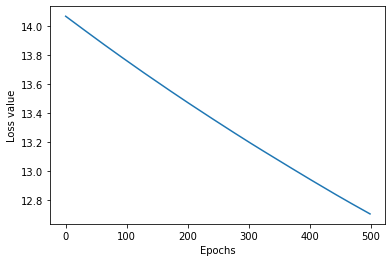

In [68]:
svm, svm_loss, svm_val_acc = SVM(x_train[:1000],y_train[:1000],1e-10,0,500,x_val[:100],y_val[:100])

Loss function used: softmax
----------------------------------


  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 0/500 | Training loss: 3.80 | Training accuracy: 0.11 | Validation accuracy: 0.10
EPOCH 1/500 | Training loss: 3.12 | Training accuracy: 0.11 | Validation accuracy: 0.08
EPOCH 2/500 | Training loss: 2.77 | Training accuracy: 0.12 | Validation accuracy: 0.14
EPOCH 3/500 | Training loss: 2.60 | Training accuracy: 0.13 | Validation accuracy: 0.14
EPOCH 4/500 | Training loss: 2.52 | Training accuracy: 0.12 | Validation accuracy: 0.14
EPOCH 5/500 | Training loss: 2.47 | Training accuracy: 0.14 | Validation accuracy: 0.14
EPOCH 6/500 | Training loss: 2.45 | Training accuracy: 0.14 | Validation accuracy: 0.15
EPOCH 7/500 | Training loss: 2.43 | Training accuracy: 0.14 | Validation accuracy: 0.15
EPOCH 8/500 | Training loss: 2.42 | Training accuracy: 0.14 | Validation accuracy: 0.15
EPOCH 9/500 | Training loss: 2.41 | Training accuracy: 0.14 | Validation accuracy: 0.17
EPOCH 10/500 | Training loss: 2.41 | Training accuracy: 0.15 | Validation accuracy: 0.17
EPOCH 11/500 | Training loss: 2

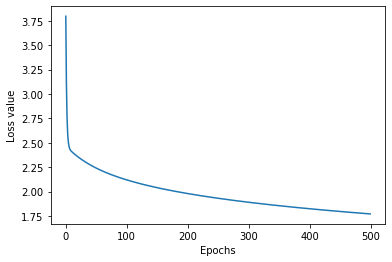

In [69]:
softmax,sft_loss, softmax_val_acc = Softmax(x_train[:1000],y_train[:1000],1e-7,0,500,x_val[:100],y_val[:100])

## Test Function

In [70]:
def model_test(model):
  '''
  Model Testing function

  Inputs:
    - model: Model weights to test
  '''
  predictions = predict(model,x_test)

  print(classification_report(y_test,predictions)) 

In [71]:
model_test(svm)

              precision    recall  f1-score   support

           0       0.25      0.01      0.01      1181
           1       0.18      0.05      0.08      1188
           2       0.08      0.04      0.05      1232
           3       0.15      0.01      0.02      1274
           4       0.04      0.00      0.00      1179
           5       0.07      0.00      0.00      1230
           6       0.10      0.51      0.17      1123
           7       0.00      0.00      0.00      1217
           8       0.09      0.16      0.11      1189
           9       0.06      0.15      0.08      1187

    accuracy                           0.09     12000
   macro avg       0.10      0.09      0.05     12000
weighted avg       0.10      0.09      0.05     12000



In [72]:
model_test(softmax)

              precision    recall  f1-score   support

           0       0.32      0.44      0.37      1181
           1       0.29      0.35      0.32      1188
           2       0.17      0.15      0.16      1232
           3       0.19      0.12      0.15      1274
           4       0.21      0.17      0.19      1179
           5       0.27      0.32      0.29      1230
           6       0.27      0.29      0.28      1123
           7       0.25      0.24      0.24      1217
           8       0.35      0.35      0.35      1189
           9       0.33      0.32      0.33      1187

    accuracy                           0.27     12000
   macro avg       0.27      0.27      0.27     12000
weighted avg       0.26      0.27      0.27     12000



## Grid Search

In [77]:
def grid_search(model='softmax'):
  '''
  Grid search function to find best learning rate and regularization coefficient based on Validation accuracy

  Inputs: 
    - model: Model to grid search on.
          2 options - 'softmax' or 'hinge'

  '''

  history = []

  for alpha in [1e-5,1e-6,1e-7,1e-8,1e-9,1e-10]:

    for reg in [1e1,1e2,1e3,1e4,1e5]:
      
      if model == 'softmax':

        softmax,softmax_loss, val_acc = Softmax(x_train[:100],y_train[:100],alpha,reg,10,x_val[:100],y_val[:100])
        print()
      
      else:

        svm, svm_loss, val_acc = SVM(x_train[:100],y_train[:100],alpha,reg,10,x_val[:100],y_val[:100])
        print()

      print("Learning Rate: {} | Regularization: {} | Maximum Validation Accuracy: {}".format(alpha,reg,max(val_acc)))
      print()

      history.append((alpha,reg,max(val_acc)))

  best = max(history,key=lambda item:item[2])

  print('Best Hyperparameters: Learning Rate {} | Regularization: {}'.format(best[0],best[1]))
  print()

  return history # List of tuples with elements (Learning Rate, Regularization, Validation Accuracy)

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 5.91 | Training accuracy: 0.20 | Validation accuracy: 0.08
EPOCH 1/10 | Training loss: 77.71 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 2/10 | Training loss: 167.11 | Training accuracy: 0.13 | Validation accuracy: 0.14
EPOCH 3/10 | Training loss: 182.73 | Training accuracy: 0.09 | Validation accuracy: 0.09
EPOCH 4/10 | Training loss: 210.83 | Training accuracy: 0.10 | Validation accuracy: 0.07
EPOCH 5/10 | Training loss: 196.47 | Training accuracy: 0.11 | Validation accuracy: 0.07
EPOCH 6/10 | Training loss: 168.03 | Training accuracy: 0.23 | Validation accuracy: 0.10
EPOCH 7/10 | Training loss: 183.01 | Training accuracy: 0.06 | Validation accuracy: 0.14
EPOCH 8/10 | Training loss: 174.76 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 9/10 | Training loss: nan | Training accuracy: 0.14 | Validation accuracy: 0.10



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


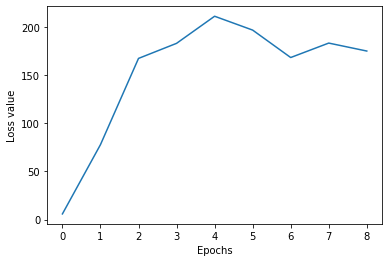


Learning Rate: 1e-05 | Regularization: 10.0 | Maximum Validation Accuracy: 0.14

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 5.77 | Training accuracy: 0.20 | Validation accuracy: 0.08
EPOCH 1/10 | Training loss: 75.83 | Training accuracy: 0.22 | Validation accuracy: 0.09
EPOCH 2/10 | Training loss: 135.84 | Training accuracy: 0.10 | Validation accuracy: 0.07
EPOCH 3/10 | Training loss: 135.21 | Training accuracy: 0.08 | Validation accuracy: 0.08
EPOCH 4/10 | Training loss: 122.51 | Training accuracy: 0.11 | Validation accuracy: 0.15
EPOCH 5/10 | Training loss: 98.33 | Training accuracy: 0.23 | Validation accuracy: 0.15
EPOCH 6/10 | Training loss: inf | Training accuracy: 0.13 | Validation accuracy: 0.14


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


EPOCH 7/10 | Training loss: inf | Training accuracy: 0.22 | Validation accuracy: 0.08
EPOCH 8/10 | Training loss: inf | Training accuracy: 0.20 | Validation accuracy: 0.08
EPOCH 9/10 | Training loss: nan | Training accuracy: 0.14 | Validation accuracy: 0.10



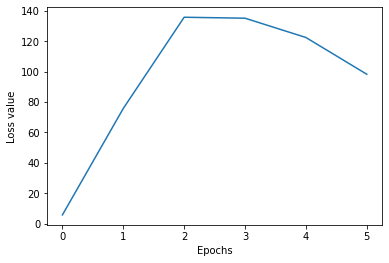


Learning Rate: 1e-05 | Regularization: 100.0 | Maximum Validation Accuracy: 0.15

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 14.70 | Training accuracy: 0.20 | Validation accuracy: 0.08
EPOCH 1/10 | Training loss: 77.86 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 2/10 | Training loss: 162.33 | Training accuracy: 0.13 | Validation accuracy: 0.14
EPOCH 3/10 | Training loss: inf | Training accuracy: 0.09 | Validation accuracy: 0.09
EPOCH 4/10 | Training loss: 209.71 | Training accuracy: 0.09 | Validation accuracy: 0.08


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


EPOCH 5/10 | Training loss: 164.88 | Training accuracy: 0.25 | Validation accuracy: 0.13
EPOCH 6/10 | Training loss: 156.63 | Training accuracy: 0.17 | Validation accuracy: 0.17
EPOCH 7/10 | Training loss: 128.69 | Training accuracy: 0.22 | Validation accuracy: 0.09
EPOCH 8/10 | Training loss: 139.96 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 9/10 | Training loss: 208.21 | Training accuracy: 0.11 | Validation accuracy: 0.07



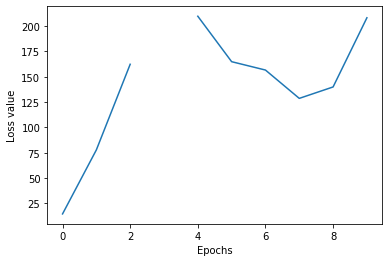


Learning Rate: 1e-05 | Regularization: 1000.0 | Maximum Validation Accuracy: 0.17

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 105.43 | Training accuracy: 0.22 | Validation accuracy: 0.11
EPOCH 1/10 | Training loss: 110.84 | Training accuracy: 0.13 | Validation accuracy: 0.14
EPOCH 2/10 | Training loss: 148.79 | Training accuracy: 0.18 | Validation accuracy: 0.11
EPOCH 3/10 | Training loss: 165.93 | Training accuracy: 0.15 | Validation accuracy: 0.08
EPOCH 4/10 | Training loss: 139.93 | Training accuracy: 0.20 | Validation accuracy: 0.08
EPOCH 5/10 | Training loss: 150.51 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 6/10 | Training loss: 195.30 | Training accuracy: 0.09 | Validation accuracy: 0.09
EPOCH 7/10 | Training loss: inf | Training accuracy: 0.09 | Validation accuracy: 0.10
EPOCH 8/10 | Training loss: 153.51 | Training accuracy: 0.27 | Validation accuracy: 0.19


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


EPOCH 9/10 | Training loss: 156.21 | Training accuracy: 0.10 | Validation accuracy: 0.07



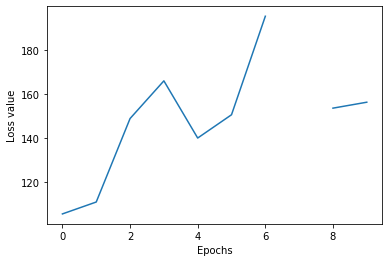


Learning Rate: 1e-05 | Regularization: 10000.0 | Maximum Validation Accuracy: 0.19

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 1029.26 | Training accuracy: 0.20 | Validation accuracy: 0.08
EPOCH 1/10 | Training loss: 1182.88 | Training accuracy: 0.08 | Validation accuracy: 0.08
EPOCH 2/10 | Training loss: inf | Training accuracy: 0.20 | Validation accuracy: 0.08
EPOCH 3/10 | Training loss: inf | Training accuracy: 0.08 | Validation accuracy: 0.08


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


EPOCH 4/10 | Training loss: nan | Training accuracy: 0.08 | Validation accuracy: 0.08
EPOCH 5/10 | Training loss: nan | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 6/10 | Training loss: nan | Training accuracy: 0.14 | Validation accuracy: 0.10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  


EPOCH 7/10 | Training loss: nan | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 8/10 | Training loss: nan | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 9/10 | Training loss: nan | Training accuracy: 0.14 | Validation accuracy: 0.10



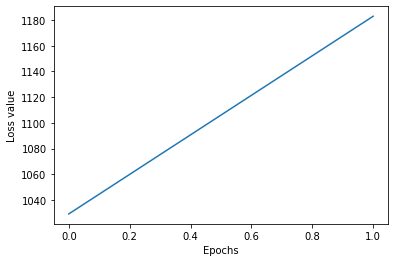


Learning Rate: 1e-05 | Regularization: 100000.0 | Maximum Validation Accuracy: 0.1

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 3.52 | Training accuracy: 0.23 | Validation accuracy: 0.08
EPOCH 1/10 | Training loss: 4.13 | Training accuracy: 0.14 | Validation accuracy: 0.15
EPOCH 2/10 | Training loss: 7.51 | Training accuracy: 0.14 | Validation accuracy: 0.08
EPOCH 3/10 | Training loss: 7.04 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 4/10 | Training loss: 7.32 | Training accuracy: 0.21 | Validation accuracy: 0.08
EPOCH 5/10 | Training loss: 12.77 | Training accuracy: 0.13 | Validation accuracy: 0.09
EPOCH 6/10 | Training loss: 14.15 | Training accuracy: 0.15 | Validation accuracy: 0.14
EPOCH 7/10 | Training loss: 12.01 | Training accuracy: 0.16 | Validation accuracy: 0.11
EPOCH 8/10 | Training loss: 8.63 | Training accuracy: 0.27 | Validation accuracy: 0.11
EPOCH 9/10 | Training loss: 7.55 | Training accuracy: 0.14 | Validation accuracy: 0.11



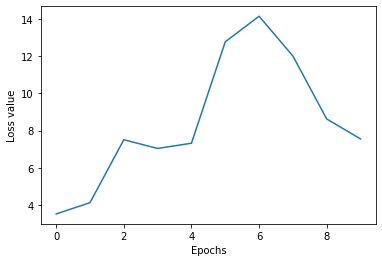


Learning Rate: 1e-06 | Regularization: 10.0 | Maximum Validation Accuracy: 0.15

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 5.25 | Training accuracy: 0.19 | Validation accuracy: 0.09
EPOCH 1/10 | Training loss: 7.45 | Training accuracy: 0.11 | Validation accuracy: 0.10
EPOCH 2/10 | Training loss: 10.86 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 3/10 | Training loss: 10.49 | Training accuracy: 0.11 | Validation accuracy: 0.06
EPOCH 4/10 | Training loss: 10.11 | Training accuracy: 0.20 | Validation accuracy: 0.08
EPOCH 5/10 | Training loss: 11.79 | Training accuracy: 0.08 | Validation accuracy: 0.09
EPOCH 6/10 | Training loss: 12.47 | Training accuracy: 0.12 | Validation accuracy: 0.14
EPOCH 7/10 | Training loss: 8.75 | Training accuracy: 0.14 | Validation accuracy: 0.11
EPOCH 8/10 | Training loss: 8.72 | Training accuracy: 0.24 | Validation accuracy: 0.12
EPOCH 9/10 | Training loss: 9.26 | Training accuracy: 0.17 | Validation accuracy: 0.13



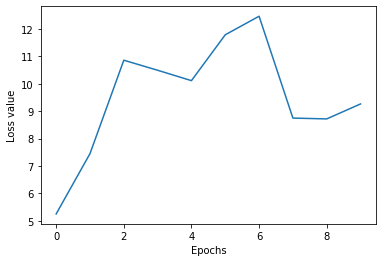


Learning Rate: 1e-06 | Regularization: 100.0 | Maximum Validation Accuracy: 0.14

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 13.40 | Training accuracy: 0.20 | Validation accuracy: 0.08
EPOCH 1/10 | Training loss: 16.83 | Training accuracy: 0.15 | Validation accuracy: 0.10
EPOCH 2/10 | Training loss: 22.65 | Training accuracy: 0.11 | Validation accuracy: 0.11
EPOCH 3/10 | Training loss: 23.42 | Training accuracy: 0.12 | Validation accuracy: 0.13
EPOCH 4/10 | Training loss: 22.34 | Training accuracy: 0.16 | Validation accuracy: 0.14
EPOCH 5/10 | Training loss: 20.82 | Training accuracy: 0.23 | Validation accuracy: 0.10
EPOCH 6/10 | Training loss: 22.02 | Training accuracy: 0.12 | Validation accuracy: 0.13
EPOCH 7/10 | Training loss: 21.47 | Training accuracy: 0.15 | Validation accuracy: 0.10
EPOCH 8/10 | Training loss: 20.61 | Training accuracy: 0.16 | Validation accuracy: 0.13
EPOCH 9/10 | Training loss: 19.65 | Training accuracy: 0.24 | Validation accuracy: 0.09



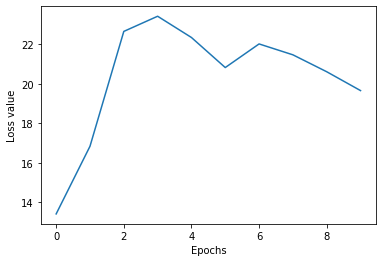


Learning Rate: 1e-06 | Regularization: 1000.0 | Maximum Validation Accuracy: 0.14

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 106.26 | Training accuracy: 0.20 | Validation accuracy: 0.08
EPOCH 1/10 | Training loss: 105.74 | Training accuracy: 0.13 | Validation accuracy: 0.14
EPOCH 2/10 | Training loss: 106.27 | Training accuracy: 0.15 | Validation accuracy: 0.10
EPOCH 3/10 | Training loss: 104.52 | Training accuracy: 0.13 | Validation accuracy: 0.08
EPOCH 4/10 | Training loss: 101.36 | Training accuracy: 0.09 | Validation accuracy: 0.11
EPOCH 5/10 | Training loss: 92.86 | Training accuracy: 0.28 | Validation accuracy: 0.08
EPOCH 6/10 | Training loss: 88.59 | Training accuracy: 0.16 | Validation accuracy: 0.12
EPOCH 7/10 | Training loss: 86.31 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 8/10 | Training loss: 81.93 | Training accuracy: 0.13 | Validation accuracy: 0.15
EPOCH 9/10 | Training loss: 80.53 | Training accuracy: 0.27 | Validation accuracy: 0.08



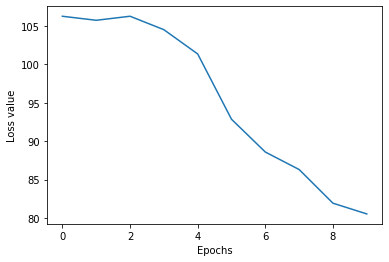


Learning Rate: 1e-06 | Regularization: 10000.0 | Maximum Validation Accuracy: 0.15

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 1022.28 | Training accuracy: 0.20 | Validation accuracy: 0.08
EPOCH 1/10 | Training loss: 659.65 | Training accuracy: 0.14 | Validation accuracy: 0.14
EPOCH 2/10 | Training loss: 429.30 | Training accuracy: 0.13 | Validation accuracy: 0.08
EPOCH 3/10 | Training loss: 277.29 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 4/10 | Training loss: 178.69 | Training accuracy: 0.20 | Validation accuracy: 0.08
EPOCH 5/10 | Training loss: 124.11 | Training accuracy: 0.13 | Validation accuracy: 0.13
EPOCH 6/10 | Training loss: 84.75 | Training accuracy: 0.13 | Validation accuracy: 0.14
EPOCH 7/10 | Training loss: 55.07 | Training accuracy: 0.27 | Validation accuracy: 0.09
EPOCH 8/10 | Training loss: 36.82 | Training accuracy: 0.20 | Validation accuracy: 0.08
EPOCH 9/10 | Training loss: 27.68 | Training accuracy: 0.14 | Validation accuracy: 0.10



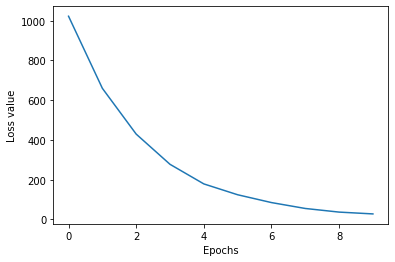


Learning Rate: 1e-06 | Regularization: 100000.0 | Maximum Validation Accuracy: 0.14

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 2.98 | Training accuracy: 0.21 | Validation accuracy: 0.08
EPOCH 1/10 | Training loss: 2.70 | Training accuracy: 0.23 | Validation accuracy: 0.15
EPOCH 2/10 | Training loss: 2.56 | Training accuracy: 0.22 | Validation accuracy: 0.13
EPOCH 3/10 | Training loss: 2.49 | Training accuracy: 0.22 | Validation accuracy: 0.13
EPOCH 4/10 | Training loss: 2.46 | Training accuracy: 0.22 | Validation accuracy: 0.16
EPOCH 5/10 | Training loss: 2.44 | Training accuracy: 0.22 | Validation accuracy: 0.16
EPOCH 6/10 | Training loss: 2.42 | Training accuracy: 0.23 | Validation accuracy: 0.17
EPOCH 7/10 | Training loss: 2.41 | Training accuracy: 0.23 | Validation accuracy: 0.18
EPOCH 8/10 | Training loss: 2.39 | Training accuracy: 0.23 | Validation accuracy: 0.17
EPOCH 9/10 | Training loss: 2.38 | Training accuracy: 0.23 | Validation accuracy: 0.17



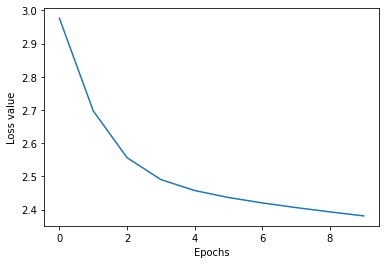


Learning Rate: 1e-07 | Regularization: 10.0 | Maximum Validation Accuracy: 0.18

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 5.08 | Training accuracy: 0.12 | Validation accuracy: 0.15
EPOCH 1/10 | Training loss: 4.41 | Training accuracy: 0.13 | Validation accuracy: 0.16
EPOCH 2/10 | Training loss: 3.91 | Training accuracy: 0.20 | Validation accuracy: 0.15
EPOCH 3/10 | Training loss: 3.60 | Training accuracy: 0.20 | Validation accuracy: 0.16
EPOCH 4/10 | Training loss: 3.45 | Training accuracy: 0.21 | Validation accuracy: 0.16
EPOCH 5/10 | Training loss: 3.39 | Training accuracy: 0.21 | Validation accuracy: 0.15
EPOCH 6/10 | Training loss: 3.35 | Training accuracy: 0.21 | Validation accuracy: 0.14
EPOCH 7/10 | Training loss: 3.32 | Training accuracy: 0.20 | Validation accuracy: 0.13
EPOCH 8/10 | Training loss: 3.29 | Training accuracy: 0.20 | Validation accuracy: 0.13
EPOCH 9/10 | Training loss: 3.27 | Training accuracy: 0.20 | Validation accuracy: 0.15



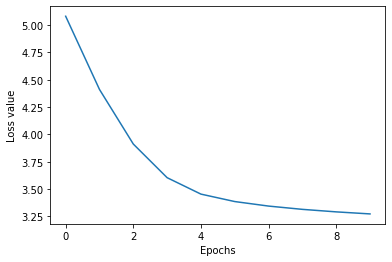


Learning Rate: 1e-07 | Regularization: 100.0 | Maximum Validation Accuracy: 0.16

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 14.43 | Training accuracy: 0.09 | Validation accuracy: 0.09
EPOCH 1/10 | Training loss: 13.52 | Training accuracy: 0.09 | Validation accuracy: 0.07
EPOCH 2/10 | Training loss: 13.13 | Training accuracy: 0.13 | Validation accuracy: 0.08
EPOCH 3/10 | Training loss: 12.93 | Training accuracy: 0.15 | Validation accuracy: 0.10
EPOCH 4/10 | Training loss: 12.86 | Training accuracy: 0.17 | Validation accuracy: 0.09
EPOCH 5/10 | Training loss: 12.81 | Training accuracy: 0.18 | Validation accuracy: 0.09
EPOCH 6/10 | Training loss: 12.78 | Training accuracy: 0.21 | Validation accuracy: 0.09
EPOCH 7/10 | Training loss: 12.75 | Training accuracy: 0.22 | Validation accuracy: 0.09
EPOCH 8/10 | Training loss: 12.72 | Training accuracy: 0.23 | Validation accuracy: 0.09
EPOCH 9/10 | Training loss: 12.70 | Training accuracy: 0.23 | Validation accuracy: 0.09



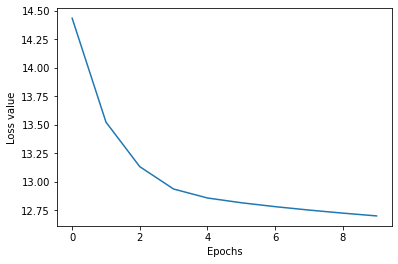


Learning Rate: 1e-07 | Regularization: 1000.0 | Maximum Validation Accuracy: 0.1

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 107.45 | Training accuracy: 0.08 | Validation accuracy: 0.11
EPOCH 1/10 | Training loss: 105.72 | Training accuracy: 0.06 | Validation accuracy: 0.11
EPOCH 2/10 | Training loss: 104.59 | Training accuracy: 0.10 | Validation accuracy: 0.09
EPOCH 3/10 | Training loss: 103.75 | Training accuracy: 0.12 | Validation accuracy: 0.06
EPOCH 4/10 | Training loss: 103.15 | Training accuracy: 0.14 | Validation accuracy: 0.07
EPOCH 5/10 | Training loss: 102.65 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 6/10 | Training loss: 102.19 | Training accuracy: 0.14 | Validation accuracy: 0.11
EPOCH 7/10 | Training loss: 101.74 | Training accuracy: 0.18 | Validation accuracy: 0.11
EPOCH 8/10 | Training loss: 101.31 | Training accuracy: 0.18 | Validation accuracy: 0.11
EPOCH 9/10 | Training loss: 100.89 | Training accuracy: 0.18 | Validation accuracy: 0.11



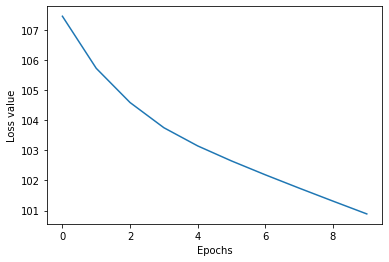


Learning Rate: 1e-07 | Regularization: 10000.0 | Maximum Validation Accuracy: 0.11

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 1024.54 | Training accuracy: 0.06 | Validation accuracy: 0.06
EPOCH 1/10 | Training loss: 983.42 | Training accuracy: 0.09 | Validation accuracy: 0.06
EPOCH 2/10 | Training loss: 944.21 | Training accuracy: 0.08 | Validation accuracy: 0.09
EPOCH 3/10 | Training loss: 906.68 | Training accuracy: 0.05 | Validation accuracy: 0.09
EPOCH 4/10 | Training loss: 870.72 | Training accuracy: 0.08 | Validation accuracy: 0.08
EPOCH 5/10 | Training loss: 836.20 | Training accuracy: 0.09 | Validation accuracy: 0.09
EPOCH 6/10 | Training loss: 803.08 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 7/10 | Training loss: 771.29 | Training accuracy: 0.15 | Validation accuracy: 0.13
EPOCH 8/10 | Training loss: 740.77 | Training accuracy: 0.16 | Validation accuracy: 0.14
EPOCH 9/10 | Training loss: 711.48 | Training accuracy: 0.18 | Validation accuracy: 0.14



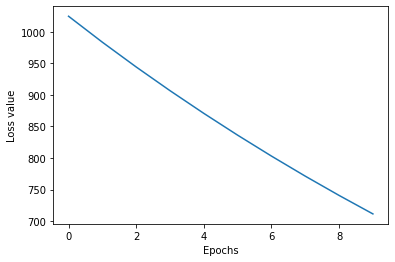


Learning Rate: 1e-07 | Regularization: 100000.0 | Maximum Validation Accuracy: 0.14

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 3.57 | Training accuracy: 0.14 | Validation accuracy: 0.07
EPOCH 1/10 | Training loss: 3.52 | Training accuracy: 0.16 | Validation accuracy: 0.07
EPOCH 2/10 | Training loss: 3.48 | Training accuracy: 0.20 | Validation accuracy: 0.07
EPOCH 3/10 | Training loss: 3.44 | Training accuracy: 0.20 | Validation accuracy: 0.07
EPOCH 4/10 | Training loss: 3.40 | Training accuracy: 0.20 | Validation accuracy: 0.07
EPOCH 5/10 | Training loss: 3.37 | Training accuracy: 0.20 | Validation accuracy: 0.07
EPOCH 6/10 | Training loss: 3.34 | Training accuracy: 0.20 | Validation accuracy: 0.07
EPOCH 7/10 | Training loss: 3.31 | Training accuracy: 0.20 | Validation accuracy: 0.06
EPOCH 8/10 | Training loss: 3.28 | Training accuracy: 0.20 | Validation accuracy: 0.07
EPOCH 9/10 | Training loss: 3.25 | Training accuracy: 0.20 | Validation accuracy: 0.07



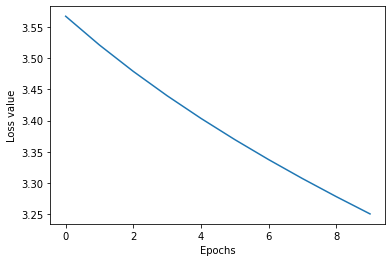


Learning Rate: 1e-08 | Regularization: 10.0 | Maximum Validation Accuracy: 0.07

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 4.19 | Training accuracy: 0.10 | Validation accuracy: 0.10
EPOCH 1/10 | Training loss: 4.12 | Training accuracy: 0.08 | Validation accuracy: 0.12
EPOCH 2/10 | Training loss: 4.07 | Training accuracy: 0.09 | Validation accuracy: 0.13
EPOCH 3/10 | Training loss: 4.02 | Training accuracy: 0.10 | Validation accuracy: 0.13
EPOCH 4/10 | Training loss: 3.97 | Training accuracy: 0.12 | Validation accuracy: 0.14
EPOCH 5/10 | Training loss: 3.93 | Training accuracy: 0.12 | Validation accuracy: 0.14
EPOCH 6/10 | Training loss: 3.89 | Training accuracy: 0.12 | Validation accuracy: 0.15
EPOCH 7/10 | Training loss: 3.86 | Training accuracy: 0.12 | Validation accuracy: 0.14
EPOCH 8/10 | Training loss: 3.83 | Training accuracy: 0.12 | Validation accuracy: 0.15
EPOCH 9/10 | Training loss: 3.80 | Training accuracy: 0.12 | Validation accuracy: 0.14



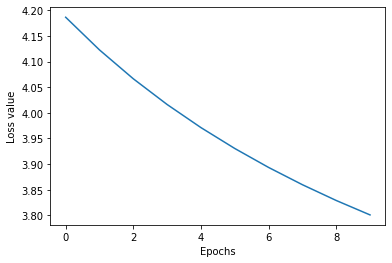


Learning Rate: 1e-08 | Regularization: 100.0 | Maximum Validation Accuracy: 0.15

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 13.56 | Training accuracy: 0.12 | Validation accuracy: 0.14
EPOCH 1/10 | Training loss: 13.48 | Training accuracy: 0.13 | Validation accuracy: 0.14
EPOCH 2/10 | Training loss: 13.41 | Training accuracy: 0.13 | Validation accuracy: 0.13
EPOCH 3/10 | Training loss: 13.35 | Training accuracy: 0.14 | Validation accuracy: 0.12
EPOCH 4/10 | Training loss: 13.29 | Training accuracy: 0.13 | Validation accuracy: 0.12
EPOCH 5/10 | Training loss: 13.24 | Training accuracy: 0.15 | Validation accuracy: 0.12
EPOCH 6/10 | Training loss: 13.19 | Training accuracy: 0.16 | Validation accuracy: 0.13
EPOCH 7/10 | Training loss: 13.15 | Training accuracy: 0.16 | Validation accuracy: 0.12
EPOCH 8/10 | Training loss: 13.12 | Training accuracy: 0.16 | Validation accuracy: 0.13
EPOCH 9/10 | Training loss: 13.08 | Training accuracy: 0.15 | Validation accuracy: 0.12



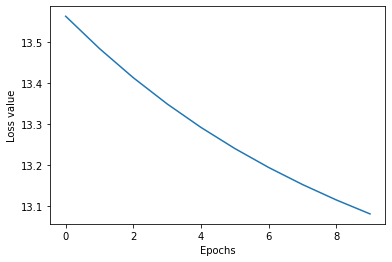


Learning Rate: 1e-08 | Regularization: 1000.0 | Maximum Validation Accuracy: 0.14

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 106.14 | Training accuracy: 0.17 | Validation accuracy: 0.10
EPOCH 1/10 | Training loss: 106.06 | Training accuracy: 0.16 | Validation accuracy: 0.10
EPOCH 2/10 | Training loss: 105.99 | Training accuracy: 0.16 | Validation accuracy: 0.10
EPOCH 3/10 | Training loss: 105.92 | Training accuracy: 0.15 | Validation accuracy: 0.11
EPOCH 4/10 | Training loss: 105.85 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 5/10 | Training loss: 105.79 | Training accuracy: 0.14 | Validation accuracy: 0.09
EPOCH 6/10 | Training loss: 105.72 | Training accuracy: 0.15 | Validation accuracy: 0.07
EPOCH 7/10 | Training loss: 105.66 | Training accuracy: 0.16 | Validation accuracy: 0.08
EPOCH 8/10 | Training loss: 105.60 | Training accuracy: 0.16 | Validation accuracy: 0.08
EPOCH 9/10 | Training loss: 105.54 | Training accuracy: 0.17 | Validation accuracy: 0.09



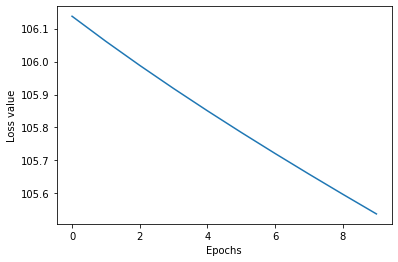


Learning Rate: 1e-08 | Regularization: 10000.0 | Maximum Validation Accuracy: 0.11

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 1028.40 | Training accuracy: 0.09 | Validation accuracy: 0.08
EPOCH 1/10 | Training loss: 1024.14 | Training accuracy: 0.06 | Validation accuracy: 0.08
EPOCH 2/10 | Training loss: 1019.93 | Training accuracy: 0.05 | Validation accuracy: 0.07
EPOCH 3/10 | Training loss: 1015.75 | Training accuracy: 0.05 | Validation accuracy: 0.07
EPOCH 4/10 | Training loss: 1011.59 | Training accuracy: 0.05 | Validation accuracy: 0.07
EPOCH 5/10 | Training loss: 1007.47 | Training accuracy: 0.05 | Validation accuracy: 0.07
EPOCH 6/10 | Training loss: 1003.37 | Training accuracy: 0.04 | Validation accuracy: 0.07
EPOCH 7/10 | Training loss: 999.30 | Training accuracy: 0.04 | Validation accuracy: 0.07
EPOCH 8/10 | Training loss: 995.25 | Training accuracy: 0.05 | Validation accuracy: 0.08
EPOCH 9/10 | Training loss: 991.22 | Training accuracy: 0.06 | Validation accuracy: 0.09



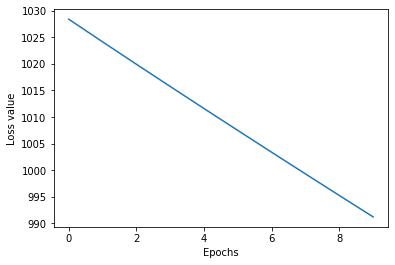


Learning Rate: 1e-08 | Regularization: 100000.0 | Maximum Validation Accuracy: 0.09

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 2.72 | Training accuracy: 0.16 | Validation accuracy: 0.07
EPOCH 1/10 | Training loss: 2.72 | Training accuracy: 0.16 | Validation accuracy: 0.07
EPOCH 2/10 | Training loss: 2.71 | Training accuracy: 0.16 | Validation accuracy: 0.07
EPOCH 3/10 | Training loss: 2.71 | Training accuracy: 0.16 | Validation accuracy: 0.07
EPOCH 4/10 | Training loss: 2.71 | Training accuracy: 0.16 | Validation accuracy: 0.07
EPOCH 5/10 | Training loss: 2.71 | Training accuracy: 0.16 | Validation accuracy: 0.07
EPOCH 6/10 | Training loss: 2.70 | Training accuracy: 0.16 | Validation accuracy: 0.06
EPOCH 7/10 | Training loss: 2.70 | Training accuracy: 0.16 | Validation accuracy: 0.06
EPOCH 8/10 | Training loss: 2.70 | Training accuracy: 0.16 | Validation accuracy: 0.06
EPOCH 9/10 | Training loss: 2.70 | Training accuracy: 0.16 | Validation accuracy: 0.06



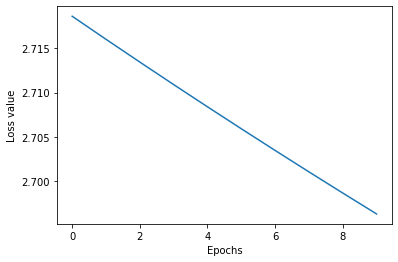


Learning Rate: 1e-09 | Regularization: 10.0 | Maximum Validation Accuracy: 0.07

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 6.39 | Training accuracy: 0.04 | Validation accuracy: 0.09
EPOCH 1/10 | Training loss: 6.37 | Training accuracy: 0.04 | Validation accuracy: 0.09
EPOCH 2/10 | Training loss: 6.35 | Training accuracy: 0.05 | Validation accuracy: 0.09
EPOCH 3/10 | Training loss: 6.32 | Training accuracy: 0.05 | Validation accuracy: 0.10
EPOCH 4/10 | Training loss: 6.30 | Training accuracy: 0.05 | Validation accuracy: 0.10
EPOCH 5/10 | Training loss: 6.28 | Training accuracy: 0.05 | Validation accuracy: 0.10
EPOCH 6/10 | Training loss: 6.25 | Training accuracy: 0.05 | Validation accuracy: 0.10
EPOCH 7/10 | Training loss: 6.23 | Training accuracy: 0.05 | Validation accuracy: 0.10
EPOCH 8/10 | Training loss: 6.21 | Training accuracy: 0.05 | Validation accuracy: 0.10
EPOCH 9/10 | Training loss: 6.19 | Training accuracy: 0.05 | Validation accuracy: 0.10



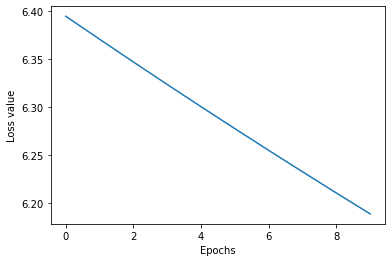


Learning Rate: 1e-09 | Regularization: 100.0 | Maximum Validation Accuracy: 0.1

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 13.88 | Training accuracy: 0.11 | Validation accuracy: 0.08
EPOCH 1/10 | Training loss: 13.87 | Training accuracy: 0.11 | Validation accuracy: 0.08
EPOCH 2/10 | Training loss: 13.86 | Training accuracy: 0.11 | Validation accuracy: 0.08
EPOCH 3/10 | Training loss: 13.84 | Training accuracy: 0.12 | Validation accuracy: 0.08
EPOCH 4/10 | Training loss: 13.83 | Training accuracy: 0.12 | Validation accuracy: 0.08
EPOCH 5/10 | Training loss: 13.82 | Training accuracy: 0.12 | Validation accuracy: 0.08
EPOCH 6/10 | Training loss: 13.81 | Training accuracy: 0.12 | Validation accuracy: 0.08
EPOCH 7/10 | Training loss: 13.79 | Training accuracy: 0.12 | Validation accuracy: 0.08
EPOCH 8/10 | Training loss: 13.78 | Training accuracy: 0.11 | Validation accuracy: 0.08
EPOCH 9/10 | Training loss: 13.77 | Training accuracy: 0.11 | Validation accuracy: 0.08



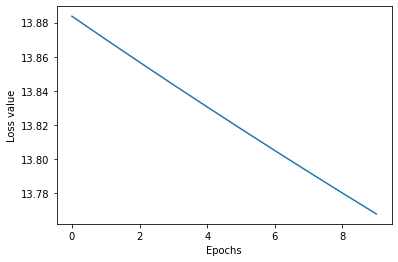


Learning Rate: 1e-09 | Regularization: 1000.0 | Maximum Validation Accuracy: 0.08

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 106.84 | Training accuracy: 0.06 | Validation accuracy: 0.13
EPOCH 1/10 | Training loss: 106.82 | Training accuracy: 0.06 | Validation accuracy: 0.13
EPOCH 2/10 | Training loss: 106.80 | Training accuracy: 0.06 | Validation accuracy: 0.13
EPOCH 3/10 | Training loss: 106.78 | Training accuracy: 0.06 | Validation accuracy: 0.13
EPOCH 4/10 | Training loss: 106.76 | Training accuracy: 0.06 | Validation accuracy: 0.13
EPOCH 5/10 | Training loss: 106.75 | Training accuracy: 0.06 | Validation accuracy: 0.13
EPOCH 6/10 | Training loss: 106.73 | Training accuracy: 0.06 | Validation accuracy: 0.13
EPOCH 7/10 | Training loss: 106.71 | Training accuracy: 0.06 | Validation accuracy: 0.13
EPOCH 8/10 | Training loss: 106.69 | Training accuracy: 0.06 | Validation accuracy: 0.13
EPOCH 9/10 | Training loss: 106.67 | Training accuracy: 0.06 | Validation accuracy: 0.13



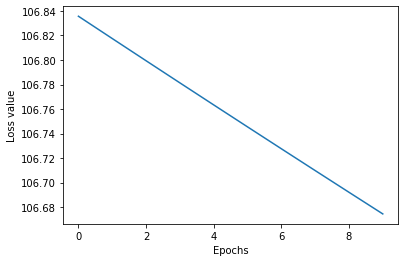


Learning Rate: 1e-09 | Regularization: 10000.0 | Maximum Validation Accuracy: 0.13

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 1024.66 | Training accuracy: 0.15 | Validation accuracy: 0.15
EPOCH 1/10 | Training loss: 1024.24 | Training accuracy: 0.15 | Validation accuracy: 0.15
EPOCH 2/10 | Training loss: 1023.82 | Training accuracy: 0.15 | Validation accuracy: 0.15
EPOCH 3/10 | Training loss: 1023.40 | Training accuracy: 0.15 | Validation accuracy: 0.15
EPOCH 4/10 | Training loss: 1022.98 | Training accuracy: 0.15 | Validation accuracy: 0.15
EPOCH 5/10 | Training loss: 1022.56 | Training accuracy: 0.15 | Validation accuracy: 0.15
EPOCH 6/10 | Training loss: 1022.15 | Training accuracy: 0.15 | Validation accuracy: 0.15
EPOCH 7/10 | Training loss: 1021.73 | Training accuracy: 0.15 | Validation accuracy: 0.15
EPOCH 8/10 | Training loss: 1021.31 | Training accuracy: 0.15 | Validation accuracy: 0.14
EPOCH 9/10 | Training loss: 1020.89 | Training accuracy: 0.15 | Validation accuracy: 0.14



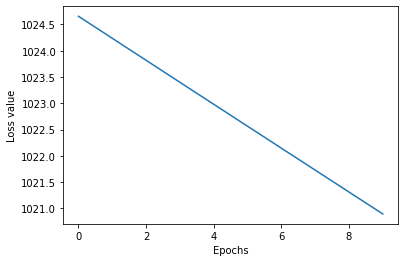


Learning Rate: 1e-09 | Regularization: 100000.0 | Maximum Validation Accuracy: 0.15

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 4.40 | Training accuracy: 0.07 | Validation accuracy: 0.09
EPOCH 1/10 | Training loss: 4.40 | Training accuracy: 0.07 | Validation accuracy: 0.09
EPOCH 2/10 | Training loss: 4.40 | Training accuracy: 0.07 | Validation accuracy: 0.09
EPOCH 3/10 | Training loss: 4.40 | Training accuracy: 0.07 | Validation accuracy: 0.09
EPOCH 4/10 | Training loss: 4.39 | Training accuracy: 0.07 | Validation accuracy: 0.09
EPOCH 5/10 | Training loss: 4.39 | Training accuracy: 0.07 | Validation accuracy: 0.09
EPOCH 6/10 | Training loss: 4.39 | Training accuracy: 0.07 | Validation accuracy: 0.09
EPOCH 7/10 | Training loss: 4.39 | Training accuracy: 0.07 | Validation accuracy: 0.09
EPOCH 8/10 | Training loss: 4.38 | Training accuracy: 0.07 | Validation accuracy: 0.09
EPOCH 9/10 | Training loss: 4.38 | Training accuracy: 0.07 | Validation accuracy: 0.09



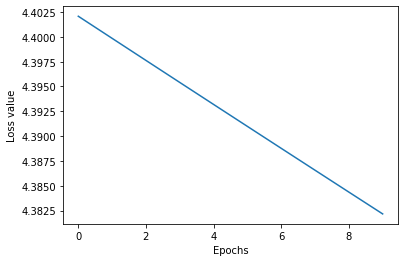


Learning Rate: 1e-10 | Regularization: 10.0 | Maximum Validation Accuracy: 0.09

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 4.48 | Training accuracy: 0.09 | Validation accuracy: 0.07
EPOCH 1/10 | Training loss: 4.48 | Training accuracy: 0.09 | Validation accuracy: 0.07
EPOCH 2/10 | Training loss: 4.48 | Training accuracy: 0.09 | Validation accuracy: 0.07
EPOCH 3/10 | Training loss: 4.47 | Training accuracy: 0.09 | Validation accuracy: 0.07
EPOCH 4/10 | Training loss: 4.47 | Training accuracy: 0.09 | Validation accuracy: 0.07
EPOCH 5/10 | Training loss: 4.47 | Training accuracy: 0.09 | Validation accuracy: 0.07
EPOCH 6/10 | Training loss: 4.47 | Training accuracy: 0.09 | Validation accuracy: 0.07
EPOCH 7/10 | Training loss: 4.47 | Training accuracy: 0.09 | Validation accuracy: 0.07
EPOCH 8/10 | Training loss: 4.47 | Training accuracy: 0.09 | Validation accuracy: 0.07
EPOCH 9/10 | Training loss: 4.47 | Training accuracy: 0.09 | Validation accuracy: 0.07



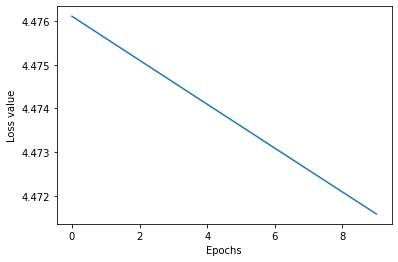


Learning Rate: 1e-10 | Regularization: 100.0 | Maximum Validation Accuracy: 0.07

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 13.68 | Training accuracy: 0.13 | Validation accuracy: 0.05
EPOCH 1/10 | Training loss: 13.68 | Training accuracy: 0.13 | Validation accuracy: 0.05
EPOCH 2/10 | Training loss: 13.68 | Training accuracy: 0.13 | Validation accuracy: 0.05
EPOCH 3/10 | Training loss: 13.68 | Training accuracy: 0.13 | Validation accuracy: 0.05
EPOCH 4/10 | Training loss: 13.68 | Training accuracy: 0.13 | Validation accuracy: 0.05
EPOCH 5/10 | Training loss: 13.68 | Training accuracy: 0.13 | Validation accuracy: 0.05
EPOCH 6/10 | Training loss: 13.68 | Training accuracy: 0.13 | Validation accuracy: 0.05
EPOCH 7/10 | Training loss: 13.68 | Training accuracy: 0.13 | Validation accuracy: 0.05
EPOCH 8/10 | Training loss: 13.68 | Training accuracy: 0.13 | Validation accuracy: 0.05
EPOCH 9/10 | Training loss: 13.68 | Training accuracy: 0.13 | Validation accuracy: 0.05



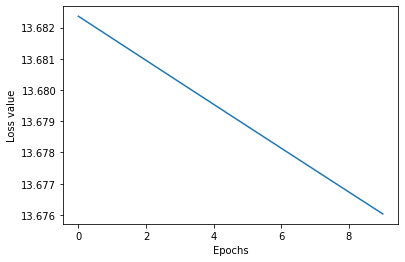


Learning Rate: 1e-10 | Regularization: 1000.0 | Maximum Validation Accuracy: 0.05

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 105.66 | Training accuracy: 0.09 | Validation accuracy: 0.12
EPOCH 1/10 | Training loss: 105.66 | Training accuracy: 0.09 | Validation accuracy: 0.12
EPOCH 2/10 | Training loss: 105.66 | Training accuracy: 0.09 | Validation accuracy: 0.12
EPOCH 3/10 | Training loss: 105.65 | Training accuracy: 0.09 | Validation accuracy: 0.12
EPOCH 4/10 | Training loss: 105.65 | Training accuracy: 0.09 | Validation accuracy: 0.12
EPOCH 5/10 | Training loss: 105.65 | Training accuracy: 0.09 | Validation accuracy: 0.12
EPOCH 6/10 | Training loss: 105.65 | Training accuracy: 0.09 | Validation accuracy: 0.12
EPOCH 7/10 | Training loss: 105.65 | Training accuracy: 0.09 | Validation accuracy: 0.12
EPOCH 8/10 | Training loss: 105.65 | Training accuracy: 0.09 | Validation accuracy: 0.12
EPOCH 9/10 | Training loss: 105.65 | Training accuracy: 0.09 | Validation accuracy: 0.12



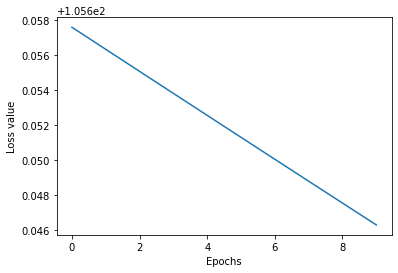


Learning Rate: 1e-10 | Regularization: 10000.0 | Maximum Validation Accuracy: 0.12

Loss function used: softmax
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 1027.51 | Training accuracy: 0.11 | Validation accuracy: 0.11
EPOCH 1/10 | Training loss: 1027.47 | Training accuracy: 0.11 | Validation accuracy: 0.11
EPOCH 2/10 | Training loss: 1027.43 | Training accuracy: 0.11 | Validation accuracy: 0.11
EPOCH 3/10 | Training loss: 1027.38 | Training accuracy: 0.11 | Validation accuracy: 0.11
EPOCH 4/10 | Training loss: 1027.34 | Training accuracy: 0.11 | Validation accuracy: 0.11
EPOCH 5/10 | Training loss: 1027.30 | Training accuracy: 0.11 | Validation accuracy: 0.11
EPOCH 6/10 | Training loss: 1027.26 | Training accuracy: 0.11 | Validation accuracy: 0.11
EPOCH 7/10 | Training loss: 1027.21 | Training accuracy: 0.11 | Validation accuracy: 0.11
EPOCH 8/10 | Training loss: 1027.17 | Training accuracy: 0.11 | Validation accuracy: 0.11
EPOCH 9/10 | Training loss: 1027.13 | Training accuracy: 0.11 | Validation accuracy: 0.11



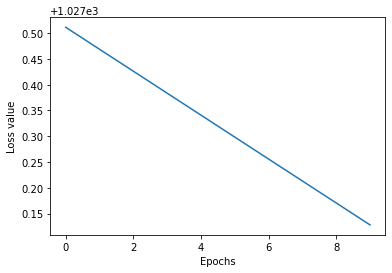


Learning Rate: 1e-10 | Regularization: 100000.0 | Maximum Validation Accuracy: 0.11

Best Hyperparameters: Learning Rate 1e-05 | Regularization: 10000.0



In [86]:
hist_softmax = grid_search('softmax')

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 19.87 | Training accuracy: 0.20 | Validation accuracy: 0.08
EPOCH 1/10 | Training loss: 1251.87 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 2/10 | Training loss: 1727.50 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 3/10 | Training loss: 2037.24 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 4/10 | Training loss: 2253.67 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 5/10 | Training loss: 2780.81 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 6/10 | Training loss: 3167.52 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 7/10 | Training loss: 3523.30 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 8/10 | Training loss: 4005.78 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 9/10 | Training loss: 4479.14 | Training accuracy: 0.14 | Validation accuracy: 0.10



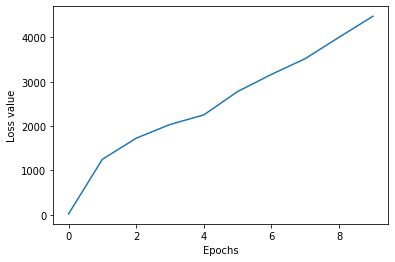


Learning Rate: 1e-05 | Regularization: 10.0 | Maximum Validation Accuracy: 0.1

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 20.43 | Training accuracy: 0.17 | Validation accuracy: 0.10
EPOCH 1/10 | Training loss: 1227.86 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 2/10 | Training loss: 1496.51 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 3/10 | Training loss: 1742.24 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 4/10 | Training loss: 2192.02 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 5/10 | Training loss: 2713.33 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 6/10 | Training loss: 3254.22 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 7/10 | Training loss: 3480.34 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 8/10 | Training loss: 3974.07 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 9/10 | Training loss: 4504.56 | Training accuracy: 0.14 | Validation accuracy: 0.10



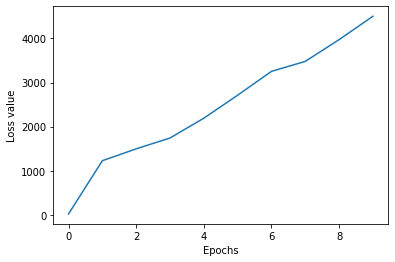


Learning Rate: 1e-05 | Regularization: 100.0 | Maximum Validation Accuracy: 0.1

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 25.35 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 1/10 | Training loss: 860.70 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 2/10 | Training loss: 1412.97 | Training accuracy: 0.23 | Validation accuracy: 0.07
EPOCH 3/10 | Training loss: 1806.78 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 4/10 | Training loss: 2186.75 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 5/10 | Training loss: 2635.79 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 6/10 | Training loss: 3017.75 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 7/10 | Training loss: 3213.50 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 8/10 | Training loss: 3779.02 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 9/10 | Training loss: 4244.99 | Training accuracy: 0.14 | Validation accuracy: 0.10



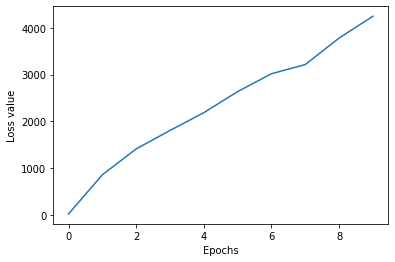


Learning Rate: 1e-05 | Regularization: 1000.0 | Maximum Validation Accuracy: 0.1

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 121.59 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 1/10 | Training loss: 1151.85 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 2/10 | Training loss: 1480.12 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 3/10 | Training loss: 1588.95 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 4/10 | Training loss: 1825.55 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 5/10 | Training loss: 2151.10 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 6/10 | Training loss: 2437.65 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 7/10 | Training loss: 2470.70 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 8/10 | Training loss: 2228.38 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 9/10 | Training loss: 2488.76 | Training accuracy: 0.14 | Validation accuracy: 0.10



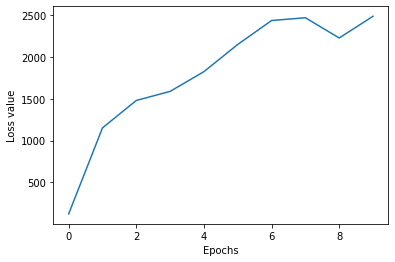


Learning Rate: 1e-05 | Regularization: 10000.0 | Maximum Validation Accuracy: 0.1

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 1034.67 | Training accuracy: 0.09 | Validation accuracy: 0.09
EPOCH 1/10 | Training loss: 3044.55 | Training accuracy: 0.20 | Validation accuracy: 0.08
EPOCH 2/10 | Training loss: 6470.95 | Training accuracy: 0.09 | Validation accuracy: 0.09
EPOCH 3/10 | Training loss: 10871.05 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 4/10 | Training loss: 19206.33 | Training accuracy: 0.09 | Validation accuracy: 0.09
EPOCH 5/10 | Training loss: 27118.83 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 6/10 | Training loss: 41353.50 | Training accuracy: 0.09 | Validation accuracy: 0.09
EPOCH 7/10 | Training loss: 53736.10 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 8/10 | Training loss: 73293.19 | Training accuracy: 0.09 | Validation accuracy: 0.09
EPOCH 9/10 | Training loss: 90164.48 | Training accuracy: 0.14 | Validation accuracy: 0.10



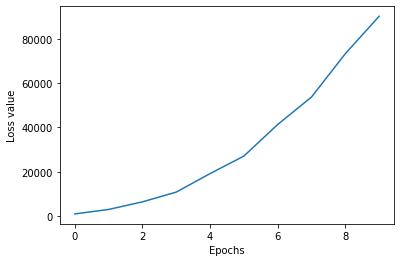


Learning Rate: 1e-05 | Regularization: 100000.0 | Maximum Validation Accuracy: 0.1

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 21.98 | Training accuracy: 0.20 | Validation accuracy: 0.09
EPOCH 1/10 | Training loss: 146.41 | Training accuracy: 0.26 | Validation accuracy: 0.12
EPOCH 2/10 | Training loss: 166.66 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 3/10 | Training loss: 211.30 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 4/10 | Training loss: 260.49 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 5/10 | Training loss: 303.19 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 6/10 | Training loss: 353.69 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 7/10 | Training loss: 399.44 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 8/10 | Training loss: 428.59 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 9/10 | Training loss: 489.01 | Training accuracy: 0.14 | Validation accuracy: 0.10



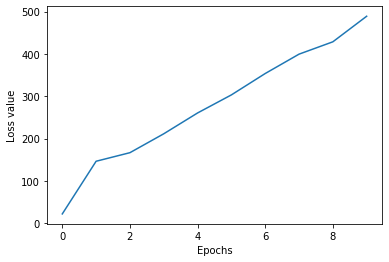


Learning Rate: 1e-06 | Regularization: 10.0 | Maximum Validation Accuracy: 0.12

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 19.48 | Training accuracy: 0.20 | Validation accuracy: 0.08
EPOCH 1/10 | Training loss: 146.80 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 2/10 | Training loss: 165.66 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 3/10 | Training loss: 189.04 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 4/10 | Training loss: 225.40 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 5/10 | Training loss: 268.96 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 6/10 | Training loss: 299.69 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 7/10 | Training loss: 363.91 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 8/10 | Training loss: 417.05 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 9/10 | Training loss: 449.56 | Training accuracy: 0.14 | Validation accuracy: 0.10



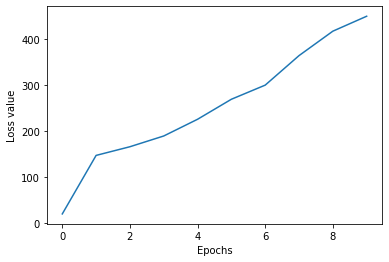


Learning Rate: 1e-06 | Regularization: 100.0 | Maximum Validation Accuracy: 0.1

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 29.98 | Training accuracy: 0.20 | Validation accuracy: 0.08
EPOCH 1/10 | Training loss: 130.51 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 2/10 | Training loss: 168.02 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 3/10 | Training loss: 195.52 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 4/10 | Training loss: 259.87 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 5/10 | Training loss: 309.12 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 6/10 | Training loss: 351.28 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 7/10 | Training loss: 403.02 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 8/10 | Training loss: 430.96 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 9/10 | Training loss: 499.25 | Training accuracy: 0.14 | Validation accuracy: 0.10



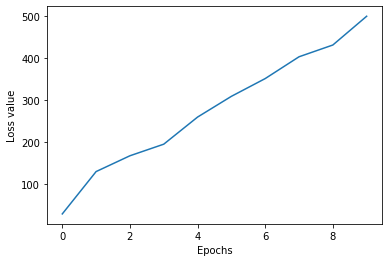


Learning Rate: 1e-06 | Regularization: 1000.0 | Maximum Validation Accuracy: 0.1

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 115.77 | Training accuracy: 0.13 | Validation accuracy: 0.14
EPOCH 1/10 | Training loss: 200.48 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 2/10 | Training loss: 223.37 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 3/10 | Training loss: 249.26 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 4/10 | Training loss: 294.25 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 5/10 | Training loss: 323.00 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 6/10 | Training loss: 386.12 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 7/10 | Training loss: 428.08 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 8/10 | Training loss: 454.13 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 9/10 | Training loss: 508.55 | Training accuracy: 0.14 | Validation accuracy: 0.10



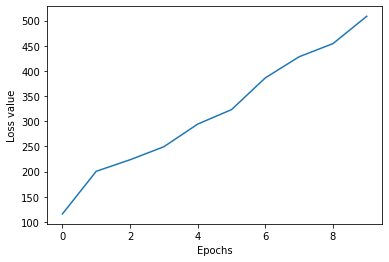


Learning Rate: 1e-06 | Regularization: 10000.0 | Maximum Validation Accuracy: 0.14

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 1042.13 | Training accuracy: 0.20 | Validation accuracy: 0.08
EPOCH 1/10 | Training loss: 762.77 | Training accuracy: 0.19 | Validation accuracy: 0.10
EPOCH 2/10 | Training loss: 559.49 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 3/10 | Training loss: 435.30 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 4/10 | Training loss: 381.14 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 5/10 | Training loss: 309.41 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 6/10 | Training loss: 299.46 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 7/10 | Training loss: 295.15 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 8/10 | Training loss: 277.09 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 9/10 | Training loss: 299.96 | Training accuracy: 0.14 | Validation accuracy: 0.10



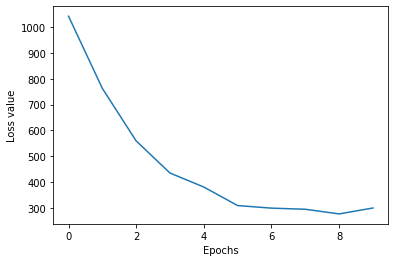


Learning Rate: 1e-06 | Regularization: 100000.0 | Maximum Validation Accuracy: 0.1

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 18.16 | Training accuracy: 0.20 | Validation accuracy: 0.08
EPOCH 1/10 | Training loss: 24.53 | Training accuracy: 0.20 | Validation accuracy: 0.08
EPOCH 2/10 | Training loss: 32.68 | Training accuracy: 0.20 | Validation accuracy: 0.08
EPOCH 3/10 | Training loss: 39.65 | Training accuracy: 0.20 | Validation accuracy: 0.08
EPOCH 4/10 | Training loss: 45.83 | Training accuracy: 0.20 | Validation accuracy: 0.08
EPOCH 5/10 | Training loss: 51.83 | Training accuracy: 0.23 | Validation accuracy: 0.09
EPOCH 6/10 | Training loss: 57.20 | Training accuracy: 0.15 | Validation accuracy: 0.10
EPOCH 7/10 | Training loss: 62.18 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 8/10 | Training loss: 67.42 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 9/10 | Training loss: 72.53 | Training accuracy: 0.14 | Validation accuracy: 0.10



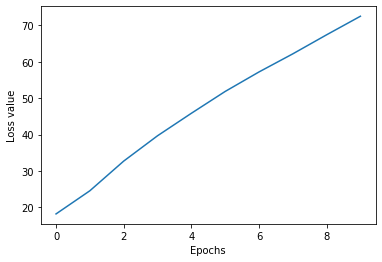


Learning Rate: 1e-07 | Regularization: 10.0 | Maximum Validation Accuracy: 0.1

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 21.62 | Training accuracy: 0.20 | Validation accuracy: 0.08
EPOCH 1/10 | Training loss: 21.91 | Training accuracy: 0.21 | Validation accuracy: 0.06
EPOCH 2/10 | Training loss: 24.14 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 3/10 | Training loss: 27.27 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 4/10 | Training loss: 30.09 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 5/10 | Training loss: 33.30 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 6/10 | Training loss: 37.06 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 7/10 | Training loss: 41.79 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 8/10 | Training loss: 47.21 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 9/10 | Training loss: 52.85 | Training accuracy: 0.14 | Validation accuracy: 0.10



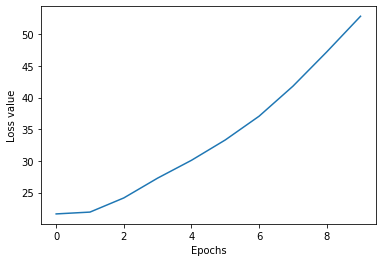


Learning Rate: 1e-07 | Regularization: 100.0 | Maximum Validation Accuracy: 0.1

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 24.90 | Training accuracy: 0.17 | Validation accuracy: 0.09
EPOCH 1/10 | Training loss: 30.51 | Training accuracy: 0.17 | Validation accuracy: 0.12
EPOCH 2/10 | Training loss: 37.68 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 3/10 | Training loss: 42.82 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 4/10 | Training loss: 47.87 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 5/10 | Training loss: 52.62 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 6/10 | Training loss: 57.25 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 7/10 | Training loss: 61.71 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 8/10 | Training loss: 66.03 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 9/10 | Training loss: 70.39 | Training accuracy: 0.14 | Validation accuracy: 0.10



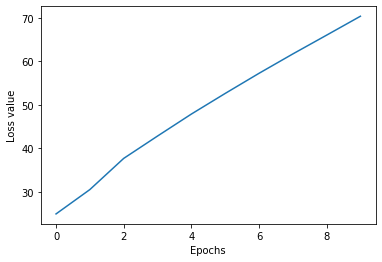


Learning Rate: 1e-07 | Regularization: 1000.0 | Maximum Validation Accuracy: 0.12

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 117.63 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 1/10 | Training loss: 120.35 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 2/10 | Training loss: 122.44 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 3/10 | Training loss: 126.88 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 4/10 | Training loss: 132.81 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 5/10 | Training loss: 138.00 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 6/10 | Training loss: 142.98 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 7/10 | Training loss: 148.41 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 8/10 | Training loss: 153.85 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 9/10 | Training loss: 159.45 | Training accuracy: 0.14 | Validation accuracy: 0.10



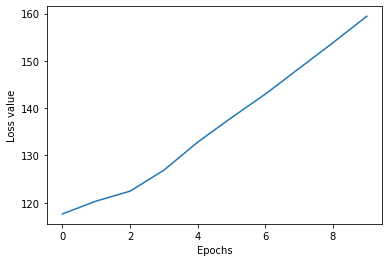


Learning Rate: 1e-07 | Regularization: 10000.0 | Maximum Validation Accuracy: 0.1

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 1050.13 | Training accuracy: 0.17 | Validation accuracy: 0.13
EPOCH 1/10 | Training loss: 1011.00 | Training accuracy: 0.14 | Validation accuracy: 0.11
EPOCH 2/10 | Training loss: 974.87 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 3/10 | Training loss: 940.74 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 4/10 | Training loss: 908.60 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 5/10 | Training loss: 878.14 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 6/10 | Training loss: 849.41 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 7/10 | Training loss: 821.72 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 8/10 | Training loss: 795.61 | Training accuracy: 0.14 | Validation accuracy: 0.10
EPOCH 9/10 | Training loss: 771.15 | Training accuracy: 0.14 | Validation accuracy: 0.10



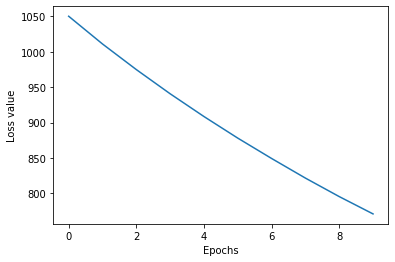


Learning Rate: 1e-07 | Regularization: 100000.0 | Maximum Validation Accuracy: 0.13

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 15.53 | Training accuracy: 0.08 | Validation accuracy: 0.08
EPOCH 1/10 | Training loss: 15.14 | Training accuracy: 0.08 | Validation accuracy: 0.08
EPOCH 2/10 | Training loss: 14.78 | Training accuracy: 0.08 | Validation accuracy: 0.09
EPOCH 3/10 | Training loss: 14.52 | Training accuracy: 0.09 | Validation accuracy: 0.09
EPOCH 4/10 | Training loss: 14.33 | Training accuracy: 0.09 | Validation accuracy: 0.09
EPOCH 5/10 | Training loss: 14.27 | Training accuracy: 0.09 | Validation accuracy: 0.09
EPOCH 6/10 | Training loss: 14.33 | Training accuracy: 0.13 | Validation accuracy: 0.09
EPOCH 7/10 | Training loss: 14.44 | Training accuracy: 0.15 | Validation accuracy: 0.08
EPOCH 8/10 | Training loss: 14.64 | Training accuracy: 0.16 | Validation accuracy: 0.07
EPOCH 9/10 | Training loss: 14.91 | Training accuracy: 0.19 | Validation accuracy: 0.05



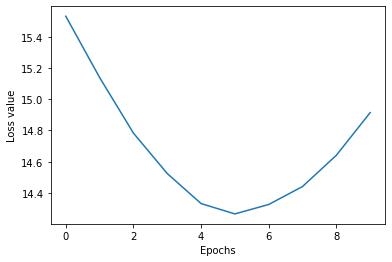


Learning Rate: 1e-08 | Regularization: 10.0 | Maximum Validation Accuracy: 0.09

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 15.24 | Training accuracy: 0.05 | Validation accuracy: 0.13
EPOCH 1/10 | Training loss: 14.55 | Training accuracy: 0.05 | Validation accuracy: 0.13
EPOCH 2/10 | Training loss: 13.94 | Training accuracy: 0.04 | Validation accuracy: 0.13
EPOCH 3/10 | Training loss: 13.39 | Training accuracy: 0.05 | Validation accuracy: 0.13
EPOCH 4/10 | Training loss: 12.91 | Training accuracy: 0.04 | Validation accuracy: 0.13
EPOCH 5/10 | Training loss: 12.46 | Training accuracy: 0.04 | Validation accuracy: 0.12
EPOCH 6/10 | Training loss: 12.04 | Training accuracy: 0.05 | Validation accuracy: 0.12
EPOCH 7/10 | Training loss: 11.68 | Training accuracy: 0.06 | Validation accuracy: 0.09
EPOCH 8/10 | Training loss: 11.36 | Training accuracy: 0.09 | Validation accuracy: 0.10
EPOCH 9/10 | Training loss: 11.10 | Training accuracy: 0.09 | Validation accuracy: 0.08



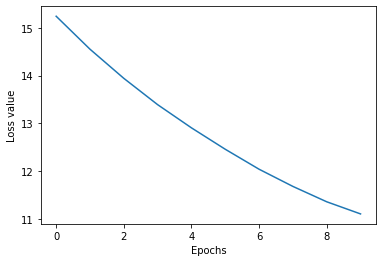


Learning Rate: 1e-08 | Regularization: 100.0 | Maximum Validation Accuracy: 0.13

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 25.20 | Training accuracy: 0.10 | Validation accuracy: 0.14
EPOCH 1/10 | Training loss: 25.42 | Training accuracy: 0.09 | Validation accuracy: 0.12
EPOCH 2/10 | Training loss: 25.68 | Training accuracy: 0.10 | Validation accuracy: 0.12
EPOCH 3/10 | Training loss: 25.99 | Training accuracy: 0.10 | Validation accuracy: 0.11
EPOCH 4/10 | Training loss: 26.36 | Training accuracy: 0.09 | Validation accuracy: 0.11
EPOCH 5/10 | Training loss: 26.76 | Training accuracy: 0.08 | Validation accuracy: 0.09
EPOCH 6/10 | Training loss: 27.26 | Training accuracy: 0.09 | Validation accuracy: 0.08
EPOCH 7/10 | Training loss: 27.84 | Training accuracy: 0.09 | Validation accuracy: 0.08
EPOCH 8/10 | Training loss: 28.49 | Training accuracy: 0.09 | Validation accuracy: 0.08
EPOCH 9/10 | Training loss: 29.19 | Training accuracy: 0.10 | Validation accuracy: 0.08



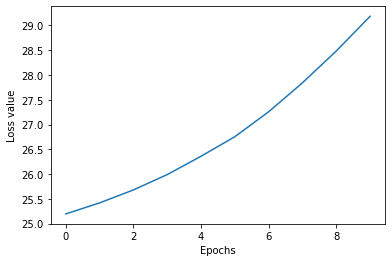


Learning Rate: 1e-08 | Regularization: 1000.0 | Maximum Validation Accuracy: 0.14

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 117.74 | Training accuracy: 0.10 | Validation accuracy: 0.11
EPOCH 1/10 | Training loss: 117.27 | Training accuracy: 0.10 | Validation accuracy: 0.09
EPOCH 2/10 | Training loss: 116.88 | Training accuracy: 0.10 | Validation accuracy: 0.12
EPOCH 3/10 | Training loss: 116.68 | Training accuracy: 0.11 | Validation accuracy: 0.13
EPOCH 4/10 | Training loss: 116.67 | Training accuracy: 0.13 | Validation accuracy: 0.13
EPOCH 5/10 | Training loss: 116.81 | Training accuracy: 0.13 | Validation accuracy: 0.12
EPOCH 6/10 | Training loss: 117.03 | Training accuracy: 0.14 | Validation accuracy: 0.13
EPOCH 7/10 | Training loss: 117.38 | Training accuracy: 0.16 | Validation accuracy: 0.14
EPOCH 8/10 | Training loss: 117.78 | Training accuracy: 0.20 | Validation accuracy: 0.16
EPOCH 9/10 | Training loss: 118.26 | Training accuracy: 0.18 | Validation accuracy: 0.15



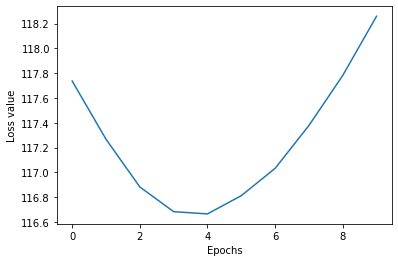


Learning Rate: 1e-08 | Regularization: 10000.0 | Maximum Validation Accuracy: 0.16

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 1033.08 | Training accuracy: 0.13 | Validation accuracy: 0.06
EPOCH 1/10 | Training loss: 1028.82 | Training accuracy: 0.13 | Validation accuracy: 0.08
EPOCH 2/10 | Training loss: 1024.62 | Training accuracy: 0.10 | Validation accuracy: 0.11
EPOCH 3/10 | Training loss: 1020.46 | Training accuracy: 0.09 | Validation accuracy: 0.11
EPOCH 4/10 | Training loss: 1016.37 | Training accuracy: 0.10 | Validation accuracy: 0.12
EPOCH 5/10 | Training loss: 1012.34 | Training accuracy: 0.11 | Validation accuracy: 0.12
EPOCH 6/10 | Training loss: 1008.40 | Training accuracy: 0.14 | Validation accuracy: 0.11
EPOCH 7/10 | Training loss: 1004.55 | Training accuracy: 0.15 | Validation accuracy: 0.11
EPOCH 8/10 | Training loss: 1000.79 | Training accuracy: 0.14 | Validation accuracy: 0.11
EPOCH 9/10 | Training loss: 997.15 | Training accuracy: 0.15 | Validation accuracy: 0.11



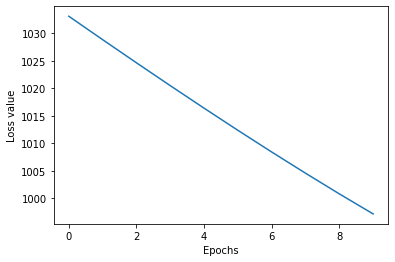


Learning Rate: 1e-08 | Regularization: 100000.0 | Maximum Validation Accuracy: 0.12

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 19.80 | Training accuracy: 0.09 | Validation accuracy: 0.06
EPOCH 1/10 | Training loss: 19.74 | Training accuracy: 0.09 | Validation accuracy: 0.06
EPOCH 2/10 | Training loss: 19.68 | Training accuracy: 0.09 | Validation accuracy: 0.06
EPOCH 3/10 | Training loss: 19.62 | Training accuracy: 0.11 | Validation accuracy: 0.06
EPOCH 4/10 | Training loss: 19.56 | Training accuracy: 0.11 | Validation accuracy: 0.06
EPOCH 5/10 | Training loss: 19.51 | Training accuracy: 0.11 | Validation accuracy: 0.06
EPOCH 6/10 | Training loss: 19.45 | Training accuracy: 0.12 | Validation accuracy: 0.06
EPOCH 7/10 | Training loss: 19.40 | Training accuracy: 0.12 | Validation accuracy: 0.05
EPOCH 8/10 | Training loss: 19.35 | Training accuracy: 0.12 | Validation accuracy: 0.05
EPOCH 9/10 | Training loss: 19.30 | Training accuracy: 0.12 | Validation accuracy: 0.05



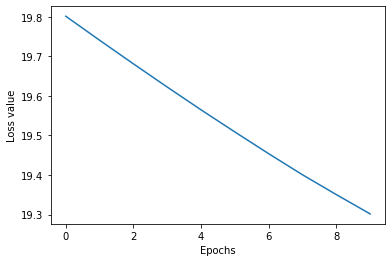


Learning Rate: 1e-09 | Regularization: 10.0 | Maximum Validation Accuracy: 0.06

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 21.96 | Training accuracy: 0.20 | Validation accuracy: 0.09
EPOCH 1/10 | Training loss: 21.94 | Training accuracy: 0.20 | Validation accuracy: 0.09
EPOCH 2/10 | Training loss: 21.93 | Training accuracy: 0.20 | Validation accuracy: 0.09
EPOCH 3/10 | Training loss: 21.92 | Training accuracy: 0.20 | Validation accuracy: 0.09
EPOCH 4/10 | Training loss: 21.91 | Training accuracy: 0.20 | Validation accuracy: 0.09
EPOCH 5/10 | Training loss: 21.90 | Training accuracy: 0.20 | Validation accuracy: 0.09
EPOCH 6/10 | Training loss: 21.89 | Training accuracy: 0.20 | Validation accuracy: 0.09
EPOCH 7/10 | Training loss: 21.88 | Training accuracy: 0.20 | Validation accuracy: 0.09
EPOCH 8/10 | Training loss: 21.88 | Training accuracy: 0.20 | Validation accuracy: 0.09
EPOCH 9/10 | Training loss: 21.87 | Training accuracy: 0.20 | Validation accuracy: 0.09



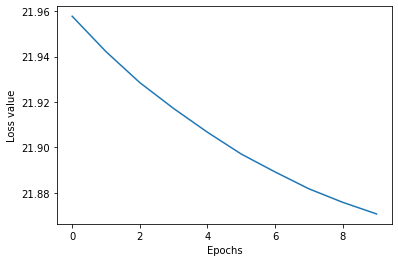


Learning Rate: 1e-09 | Regularization: 100.0 | Maximum Validation Accuracy: 0.09

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 29.99 | Training accuracy: 0.10 | Validation accuracy: 0.11
EPOCH 1/10 | Training loss: 29.94 | Training accuracy: 0.10 | Validation accuracy: 0.11
EPOCH 2/10 | Training loss: 29.88 | Training accuracy: 0.10 | Validation accuracy: 0.11
EPOCH 3/10 | Training loss: 29.83 | Training accuracy: 0.10 | Validation accuracy: 0.11
EPOCH 4/10 | Training loss: 29.78 | Training accuracy: 0.11 | Validation accuracy: 0.11
EPOCH 5/10 | Training loss: 29.73 | Training accuracy: 0.11 | Validation accuracy: 0.11
EPOCH 6/10 | Training loss: 29.68 | Training accuracy: 0.11 | Validation accuracy: 0.11
EPOCH 7/10 | Training loss: 29.63 | Training accuracy: 0.11 | Validation accuracy: 0.11
EPOCH 8/10 | Training loss: 29.58 | Training accuracy: 0.11 | Validation accuracy: 0.11
EPOCH 9/10 | Training loss: 29.53 | Training accuracy: 0.11 | Validation accuracy: 0.11



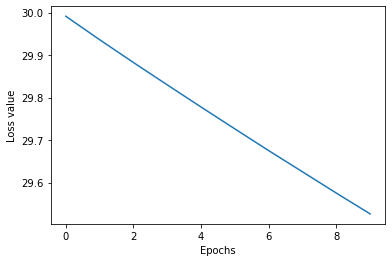


Learning Rate: 1e-09 | Regularization: 1000.0 | Maximum Validation Accuracy: 0.11

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 116.23 | Training accuracy: 0.08 | Validation accuracy: 0.08
EPOCH 1/10 | Training loss: 116.24 | Training accuracy: 0.07 | Validation accuracy: 0.08
EPOCH 2/10 | Training loss: 116.26 | Training accuracy: 0.07 | Validation accuracy: 0.08
EPOCH 3/10 | Training loss: 116.27 | Training accuracy: 0.07 | Validation accuracy: 0.08
EPOCH 4/10 | Training loss: 116.29 | Training accuracy: 0.07 | Validation accuracy: 0.08
EPOCH 5/10 | Training loss: 116.31 | Training accuracy: 0.07 | Validation accuracy: 0.08
EPOCH 6/10 | Training loss: 116.33 | Training accuracy: 0.07 | Validation accuracy: 0.08
EPOCH 7/10 | Training loss: 116.36 | Training accuracy: 0.07 | Validation accuracy: 0.08
EPOCH 8/10 | Training loss: 116.38 | Training accuracy: 0.08 | Validation accuracy: 0.08
EPOCH 9/10 | Training loss: 116.41 | Training accuracy: 0.07 | Validation accuracy: 0.09



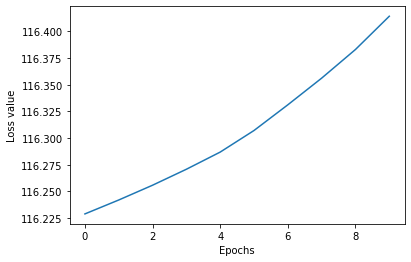


Learning Rate: 1e-09 | Regularization: 10000.0 | Maximum Validation Accuracy: 0.09

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 1042.99 | Training accuracy: 0.05 | Validation accuracy: 0.14
EPOCH 1/10 | Training loss: 1042.54 | Training accuracy: 0.06 | Validation accuracy: 0.14
EPOCH 2/10 | Training loss: 1042.09 | Training accuracy: 0.06 | Validation accuracy: 0.14
EPOCH 3/10 | Training loss: 1041.64 | Training accuracy: 0.06 | Validation accuracy: 0.14
EPOCH 4/10 | Training loss: 1041.20 | Training accuracy: 0.06 | Validation accuracy: 0.14
EPOCH 5/10 | Training loss: 1040.75 | Training accuracy: 0.06 | Validation accuracy: 0.14
EPOCH 6/10 | Training loss: 1040.31 | Training accuracy: 0.08 | Validation accuracy: 0.14
EPOCH 7/10 | Training loss: 1039.86 | Training accuracy: 0.08 | Validation accuracy: 0.14
EPOCH 8/10 | Training loss: 1039.42 | Training accuracy: 0.08 | Validation accuracy: 0.14
EPOCH 9/10 | Training loss: 1038.98 | Training accuracy: 0.08 | Validation accuracy: 0.14



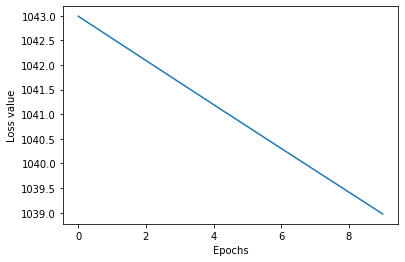


Learning Rate: 1e-09 | Regularization: 100000.0 | Maximum Validation Accuracy: 0.14

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 14.75 | Training accuracy: 0.09 | Validation accuracy: 0.07
EPOCH 1/10 | Training loss: 14.75 | Training accuracy: 0.09 | Validation accuracy: 0.07
EPOCH 2/10 | Training loss: 14.74 | Training accuracy: 0.09 | Validation accuracy: 0.07
EPOCH 3/10 | Training loss: 14.74 | Training accuracy: 0.09 | Validation accuracy: 0.07
EPOCH 4/10 | Training loss: 14.74 | Training accuracy: 0.09 | Validation accuracy: 0.07
EPOCH 5/10 | Training loss: 14.74 | Training accuracy: 0.09 | Validation accuracy: 0.07
EPOCH 6/10 | Training loss: 14.74 | Training accuracy: 0.09 | Validation accuracy: 0.07
EPOCH 7/10 | Training loss: 14.73 | Training accuracy: 0.09 | Validation accuracy: 0.07
EPOCH 8/10 | Training loss: 14.73 | Training accuracy: 0.09 | Validation accuracy: 0.07
EPOCH 9/10 | Training loss: 14.73 | Training accuracy: 0.09 | Validation accuracy: 0.07



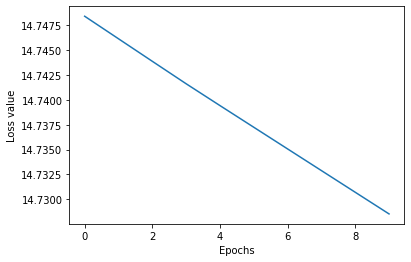


Learning Rate: 1e-10 | Regularization: 10.0 | Maximum Validation Accuracy: 0.07

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 18.70 | Training accuracy: 0.05 | Validation accuracy: 0.11
EPOCH 1/10 | Training loss: 18.70 | Training accuracy: 0.05 | Validation accuracy: 0.11
EPOCH 2/10 | Training loss: 18.70 | Training accuracy: 0.05 | Validation accuracy: 0.11
EPOCH 3/10 | Training loss: 18.70 | Training accuracy: 0.05 | Validation accuracy: 0.11
EPOCH 4/10 | Training loss: 18.70 | Training accuracy: 0.05 | Validation accuracy: 0.11
EPOCH 5/10 | Training loss: 18.70 | Training accuracy: 0.05 | Validation accuracy: 0.11
EPOCH 6/10 | Training loss: 18.70 | Training accuracy: 0.05 | Validation accuracy: 0.11
EPOCH 7/10 | Training loss: 18.70 | Training accuracy: 0.05 | Validation accuracy: 0.11
EPOCH 8/10 | Training loss: 18.70 | Training accuracy: 0.05 | Validation accuracy: 0.11
EPOCH 9/10 | Training loss: 18.70 | Training accuracy: 0.05 | Validation accuracy: 0.11



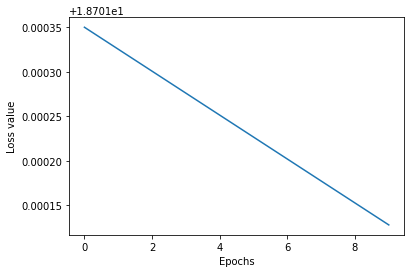


Learning Rate: 1e-10 | Regularization: 100.0 | Maximum Validation Accuracy: 0.11

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 28.11 | Training accuracy: 0.05 | Validation accuracy: 0.09
EPOCH 1/10 | Training loss: 28.11 | Training accuracy: 0.05 | Validation accuracy: 0.09
EPOCH 2/10 | Training loss: 28.10 | Training accuracy: 0.05 | Validation accuracy: 0.09
EPOCH 3/10 | Training loss: 28.09 | Training accuracy: 0.05 | Validation accuracy: 0.09
EPOCH 4/10 | Training loss: 28.09 | Training accuracy: 0.05 | Validation accuracy: 0.09
EPOCH 5/10 | Training loss: 28.08 | Training accuracy: 0.05 | Validation accuracy: 0.09
EPOCH 6/10 | Training loss: 28.08 | Training accuracy: 0.05 | Validation accuracy: 0.09
EPOCH 7/10 | Training loss: 28.07 | Training accuracy: 0.05 | Validation accuracy: 0.09
EPOCH 8/10 | Training loss: 28.07 | Training accuracy: 0.05 | Validation accuracy: 0.09
EPOCH 9/10 | Training loss: 28.06 | Training accuracy: 0.05 | Validation accuracy: 0.09



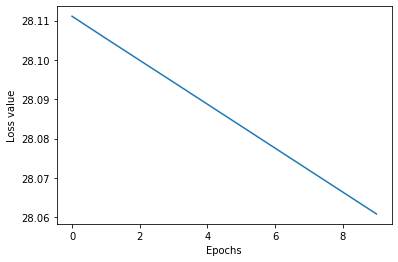


Learning Rate: 1e-10 | Regularization: 1000.0 | Maximum Validation Accuracy: 0.09

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 123.82 | Training accuracy: 0.12 | Validation accuracy: 0.13
EPOCH 1/10 | Training loss: 123.82 | Training accuracy: 0.12 | Validation accuracy: 0.13
EPOCH 2/10 | Training loss: 123.82 | Training accuracy: 0.12 | Validation accuracy: 0.13
EPOCH 3/10 | Training loss: 123.82 | Training accuracy: 0.12 | Validation accuracy: 0.14
EPOCH 4/10 | Training loss: 123.83 | Training accuracy: 0.12 | Validation accuracy: 0.13
EPOCH 5/10 | Training loss: 123.83 | Training accuracy: 0.12 | Validation accuracy: 0.13
EPOCH 6/10 | Training loss: 123.83 | Training accuracy: 0.12 | Validation accuracy: 0.13
EPOCH 7/10 | Training loss: 123.83 | Training accuracy: 0.12 | Validation accuracy: 0.13
EPOCH 8/10 | Training loss: 123.83 | Training accuracy: 0.12 | Validation accuracy: 0.13
EPOCH 9/10 | Training loss: 123.83 | Training accuracy: 0.12 | Validation accuracy: 0.13



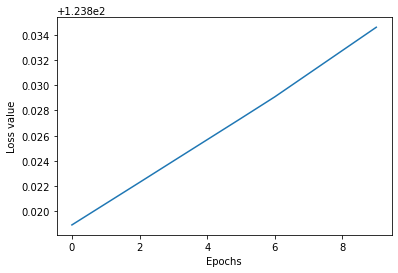


Learning Rate: 1e-10 | Regularization: 10000.0 | Maximum Validation Accuracy: 0.14

Loss function used: hinge
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0/10 | Training loss: 1037.40 | Training accuracy: 0.08 | Validation accuracy: 0.10
EPOCH 1/10 | Training loss: 1037.36 | Training accuracy: 0.08 | Validation accuracy: 0.10
EPOCH 2/10 | Training loss: 1037.32 | Training accuracy: 0.08 | Validation accuracy: 0.10
EPOCH 3/10 | Training loss: 1037.28 | Training accuracy: 0.08 | Validation accuracy: 0.10
EPOCH 4/10 | Training loss: 1037.24 | Training accuracy: 0.08 | Validation accuracy: 0.10
EPOCH 5/10 | Training loss: 1037.19 | Training accuracy: 0.08 | Validation accuracy: 0.10
EPOCH 6/10 | Training loss: 1037.15 | Training accuracy: 0.08 | Validation accuracy: 0.10
EPOCH 7/10 | Training loss: 1037.11 | Training accuracy: 0.08 | Validation accuracy: 0.10
EPOCH 8/10 | Training loss: 1037.07 | Training accuracy: 0.08 | Validation accuracy: 0.10
EPOCH 9/10 | Training loss: 1037.03 | Training accuracy: 0.08 | Validation accuracy: 0.10



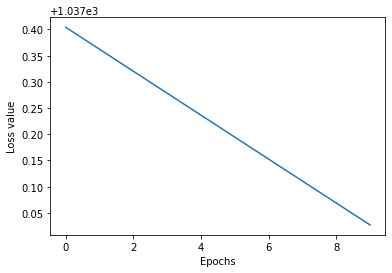


Learning Rate: 1e-10 | Regularization: 100000.0 | Maximum Validation Accuracy: 0.1

Best Hyperparameters: Learning Rate 1e-08 | Regularization: 10000.0



In [87]:
hist_svm = grid_search('svm')